# Synthetic data

In [1]:
!pwd
import os
# os.chdir('..') # for server this isnt reqd
from bilevel.synth_datagen import SynthGenLinear

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/jupyter-kriach/md_github_lat/multigroupcode/multigroup-code


In [17]:
import pickle
def save_ob(name, obj):
    with open(name, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_ob(name):
    with open(name, 'rb') as handle:
        obj = pickle.load(handle)
    return obj

In [42]:
def performance_diff(ds_obj):
    df_res = pd.concat([ds_obj.df_base_meansd, ds_obj.df_Anh_meansd], axis=1)
    df_res['base_minus_Anh'] = df_res['mean_base'] - df_res['mean_Anh']
    df_res['discount_from_base'] = (df_res['base_minus_Anh'] / df_res['mean_base'])*100
    return df_res

In [2]:
# call only one time, used the saved syn_ob below
params = {'samples': 100000, 'dim':20, 
        'group_dict': {'SEX':['male', 'female'], 'RACE': ['white', 'black', 'two-or-more','some-other', 'asian', 'native-am']},
        'prob_dict': {'SEX': [0.5, 0.5], 'RACE': [0.61, 0.12, 0.1, 0.08, 0.06, 0.03]},
        'feat_lo': 0.0, 'feat_hi': 1.0, 'w_lo': 0.0, 'w_hi': 1.0,
        'add_linear_mapping': True, 'add_quad_mapping' : False, 
        'S_lo': 0.0, 'S_hi':0.0,
        'label_noise_width':0.16, 'drop_sensitive':False
        }
syn_ob = SynthGenLinear(**params)
print(syn_ob.dperm, np.array(syn_ob.all_groupnames)[syn_ob.dperm])
df = syn_ob.df

[3 0 5 7 2 4 1 6] ['black' 'male' 'some-other' 'native-am' 'white' 'two-or-more' 'female'
 'asian']


In [4]:
# import pickle
# with open('syn_ob_saved.pickle', 'wb') as handle:
#     pickle.dump(syn_ob, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
import pickle
with open('syn_ob_saved.pickle', 'rb') as handle:
    syn_ob = pickle.load(handle)
print(syn_ob.dperm, np.array(syn_ob.all_groupnames)[syn_ob.dperm])
df = syn_ob.df

[3 0 5 7 2 4 1 6] ['black' 'male' 'some-other' 'native-am' 'white' 'two-or-more' 'female'
 'asian']


In [8]:
print(df.columns)
filter_feature = [col for col in df if col.startswith('x')]
filter_label = [col for col in df if col.startswith('y')]
filter_group = [col for col in df if col.startswith('g')]
print(filter_feature, filter_label, filter_group)

Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9',
       'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18',
       'x_19', 'g_male', 'g_female', 'g_white', 'g_black', 'g_two-or-more',
       'g_some-other', 'g_asian', 'g_native-am', 'y_male', 'y_female',
       'y_white', 'y_black', 'y_two-or-more', 'y_some-other', 'y_asian',
       'y_native-am', 'y_mean_active', 'y_min_active', 'y_max_active',
       'y_dperm_active'],
      dtype='object')
['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19'] ['y_male', 'y_female', 'y_white', 'y_black', 'y_two-or-more', 'y_some-other', 'y_asian', 'y_native-am', 'y_mean_active', 'y_min_active', 'y_max_active', 'y_dperm_active'] ['g_male', 'g_female', 'g_white', 'g_black', 'g_two-or-more', 'g_some-other', 'g_asian', 'g_native-am']


## Note about features and labels
- x_0...x_19 are the features, y_mean, min, max, dperm are the labels
- also include group membership in features!, group memberships are
    Race groups, Sex groups

In [9]:
syn_ob.A_t.shape

(100000, 8)

In [10]:
syn_ob.A_t.sum(axis=0), syn_ob.all_groupnames

(array([50105., 49895., 60803., 12093., 10159.,  8028.,  5854.,  3063.]),
 ['male',
  'female',
  'white',
  'black',
  'two-or-more',
  'some-other',
  'asian',
  'native-am'])

In [11]:
A_t = pd.DataFrame(syn_ob.A_t, columns = syn_ob.all_groupnames) # A_t dataframe
A_t['always_on'] = 1

In [12]:
df_mean = df[filter_feature+filter_group + ['y_mean_active']]
df_min = df[filter_feature+filter_group + ['y_min_active']]
df_max = df[filter_feature+filter_group + ['y_max_active']]
df_dperm = df[filter_feature+filter_group + ['y_dperm_active']]

In [13]:
from bilevel.Groupwise_seedruns import BuildGroupwise_diffseeds

## y_mean

In [16]:
%%time
ds_ymean = BuildGroupwise_diffseeds(df_mean, 'y_mean_active', A_t) # different seeds object
ds_ymean.build_all_seeds()
ds_ymean.build_df_res()
ds_ymean.build_regret_curve()

100%|██████████| 100000/100000 [00:12<00:00, 8190.19it/s]


CPU times: user 5min 55s, sys: 8.9 s, total: 6min 4s
Wall time: 2min 55s


In [18]:
save_ob('syn_ymean_seeds.pickle', ds_ymean)

In [19]:
from bilevel.Groupwise_seedruns import plot_subgroups
subgroups_list = [['male', 'female'], ['white', 'black', 'two-or-more','some-other', 'asian', 'native-am'], ['always_on']]
# plot_subgroups(ds_ob, subgroups_list)

male 50105


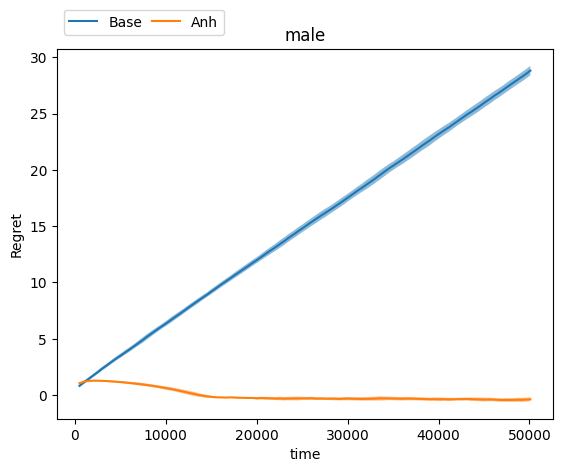

female 49895


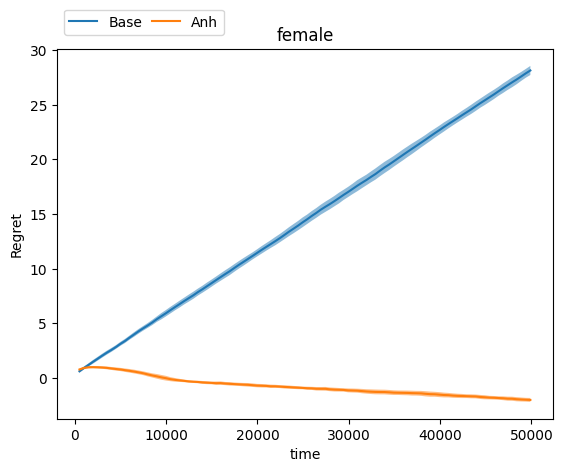

white 60803


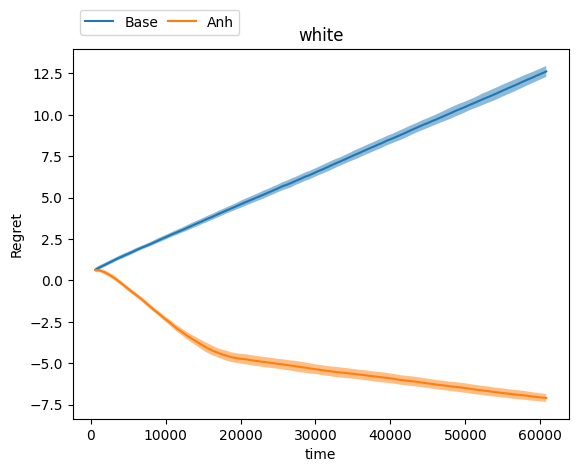

black 12093


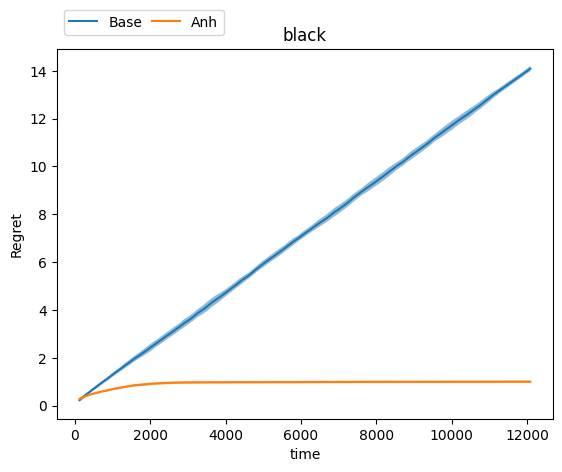

two-or-more 10159


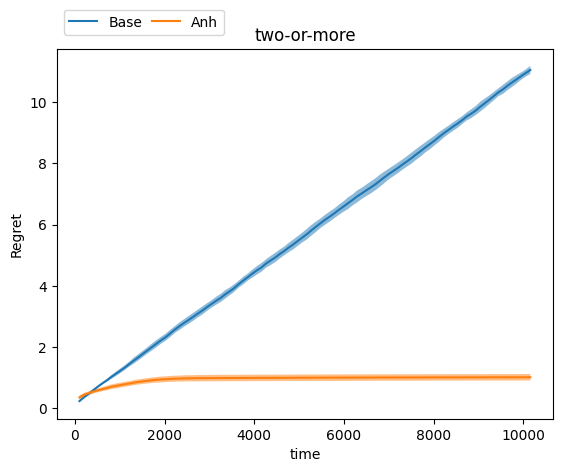

some-other 8028


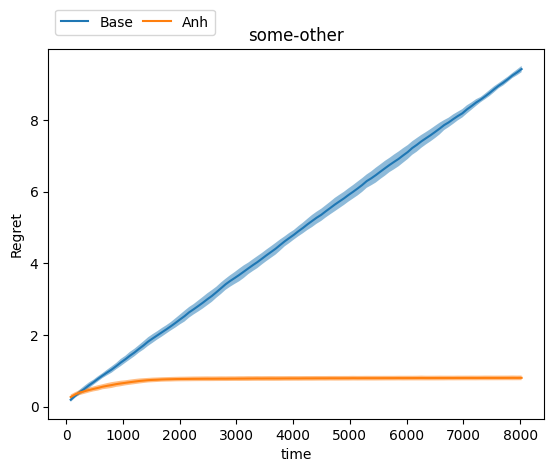

asian 5854


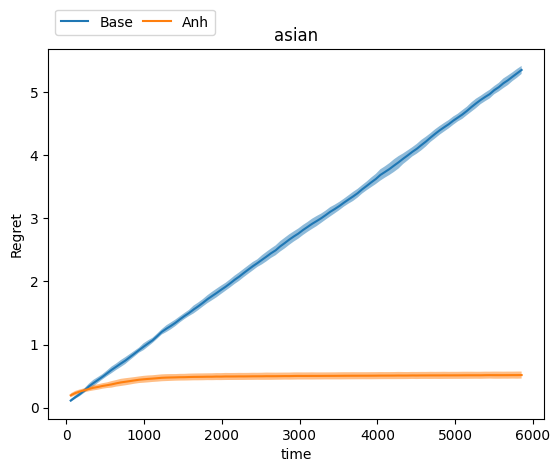

native-am 3063


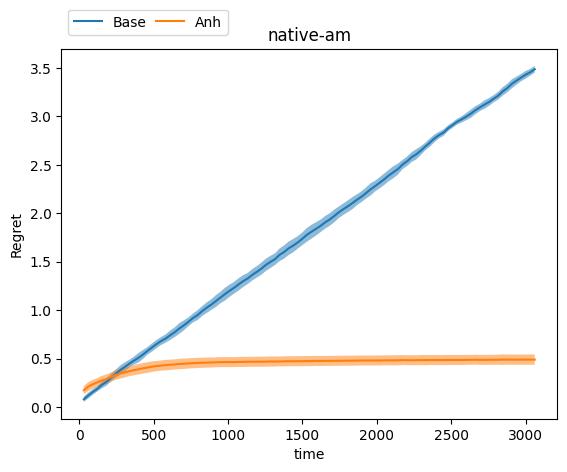

always_on 100000


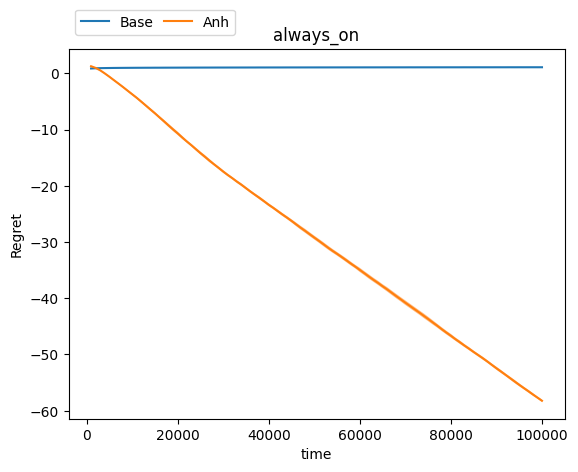

In [21]:
from bilevel.Groupwise_seedruns import plot_regret_curve_with_std
plot_regret_curve_with_std(ds_ymean)

In [29]:
pd.concat([ds_ymean.df_base_meansd, ds_ymean.df_Anh_meansd], axis=1)

,mean_base,std_base,mean_Anh,std_Anh
male,72.480970,0.438487,43.300920,0.180897
female,71.483099,0.437489,41.348306,0.192652
white,66.242034,0.351214,46.528270,0.249443
black,24.678840,0.119452,11.580542,0.056245
two-or-more,19.968421,0.140065,9.921158,0.111478
some-other,16.440802,0.091614,7.819990,0.068178
asian,10.488771,0.066394,5.650469,0.059216
native-am,6.145200,0.036412,3.148795,0.055216
always_on,143.964069,0.042196,84.649225,0.220194


## y_min

In [24]:
%%time
ds_ymin = BuildGroupwise_diffseeds(df_min, 'y_min_active', A_t) # different seeds object
ds_ymin.build_all_seeds()
ds_ymin.build_df_res()
ds_ymin.build_regret_curve()

100%|██████████| 100000/100000 [00:12<00:00, 8041.59it/s]


CPU times: user 5min 55s, sys: 8.83 s, total: 6min 4s
Wall time: 2min 57s


In [25]:
save_ob('syn_ymin_seeds.pickle', ds_ymin)

male 50105


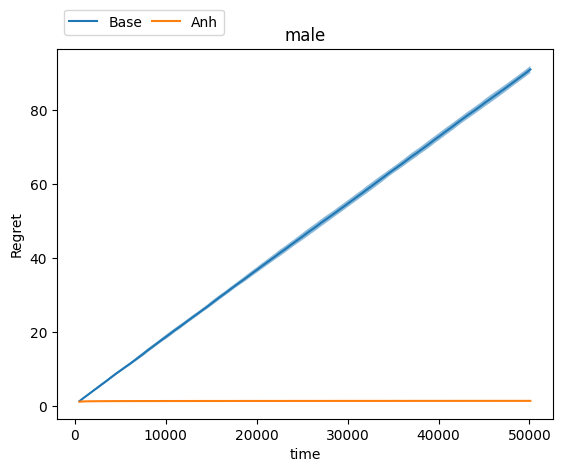

female 49895


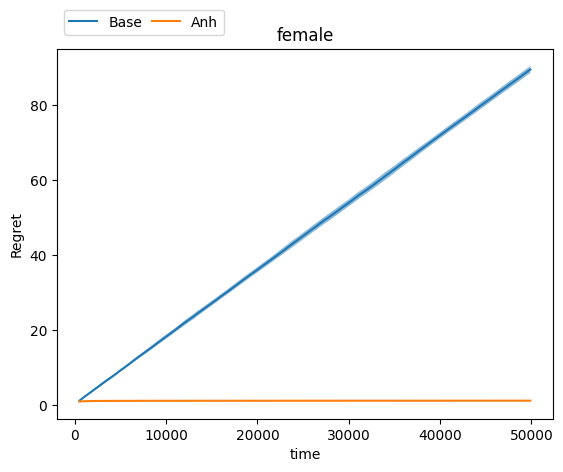

white 60803


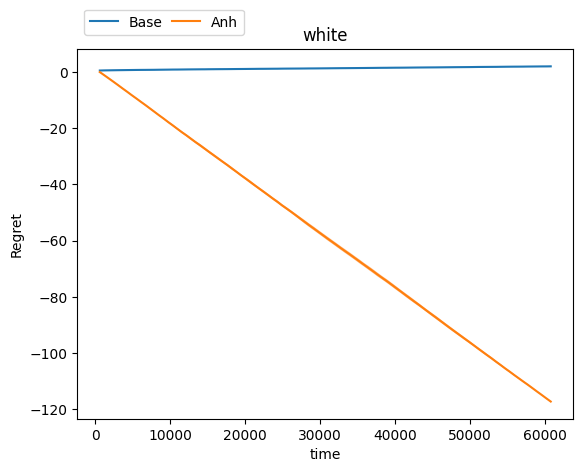

black 12093


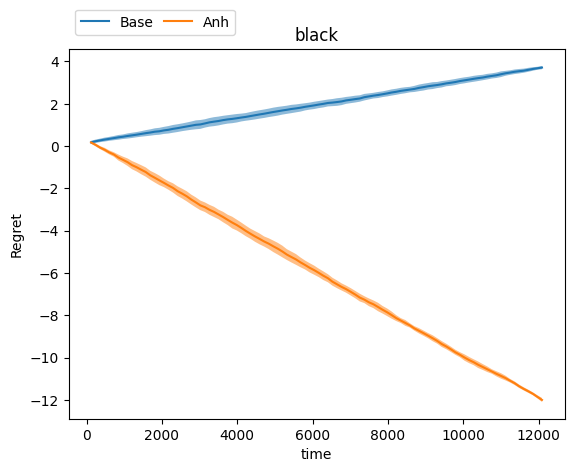

two-or-more 10159


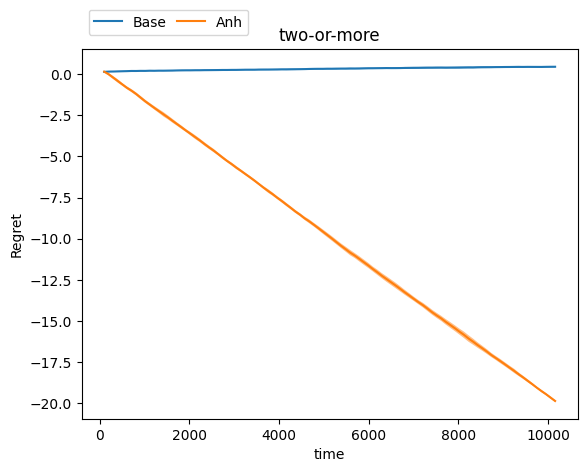

some-other 8028


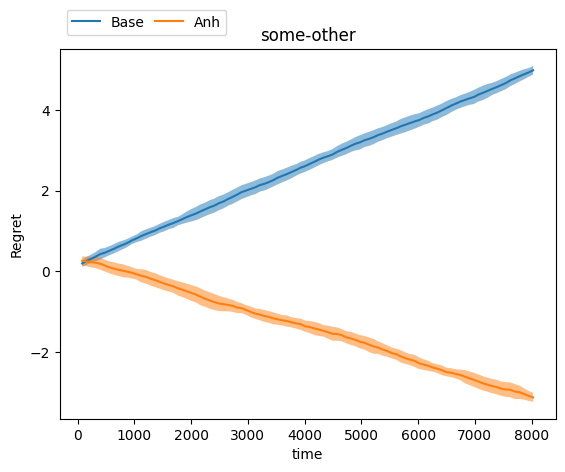

asian 5854


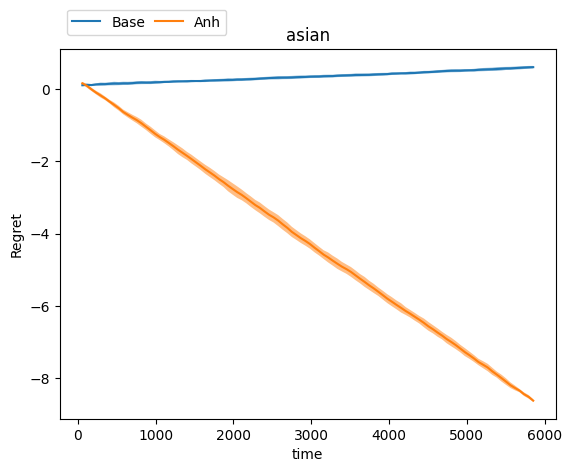

native-am 3063


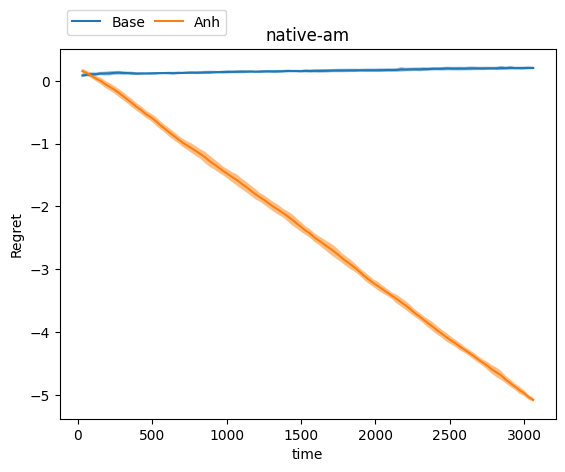

always_on 100000


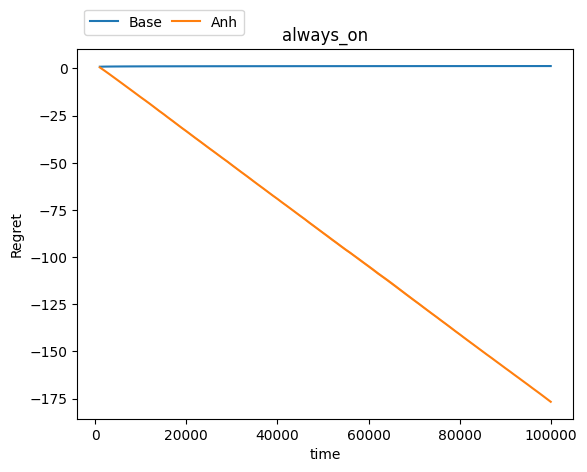

In [26]:
plot_regret_curve_with_std(ds_ymin)

In [38]:
# pd.concat([ds_ymin.df_base_meansd, ds_ymin.df_Anh_meansd], axis=1)

## y_max

In [32]:
ds_ymax = BuildGroupwise_diffseeds(df_max, 'y_max_active', A_t) # different seeds object
ds_ymax.build_all_seeds()
ds_ymax.build_df_res()
ds_ymax.build_regret_curve()

100%|██████████| 100000/100000 [00:12<00:00, 7918.67it/s]


In [33]:
save_ob('syn_ymax_seeds.pickle', ds_ymax)

male 50105


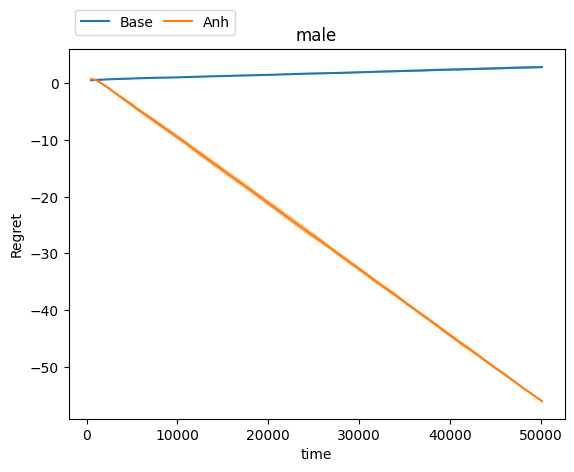

female 49895


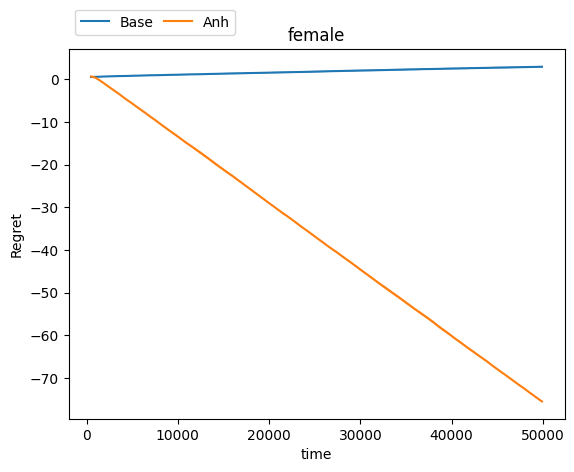

white 60803


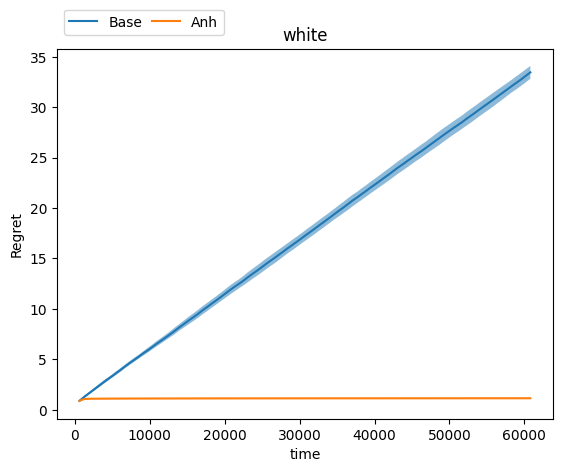

black 12093


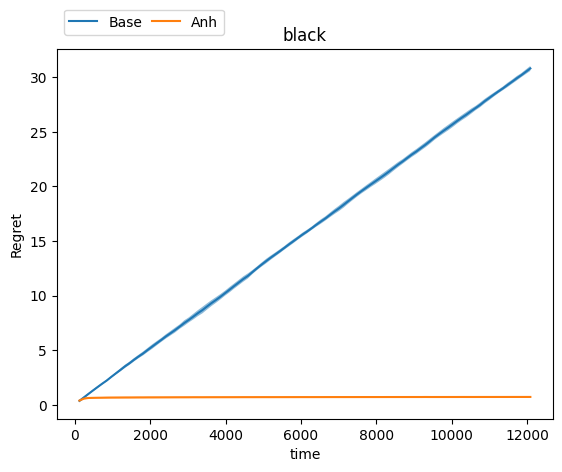

two-or-more 10159


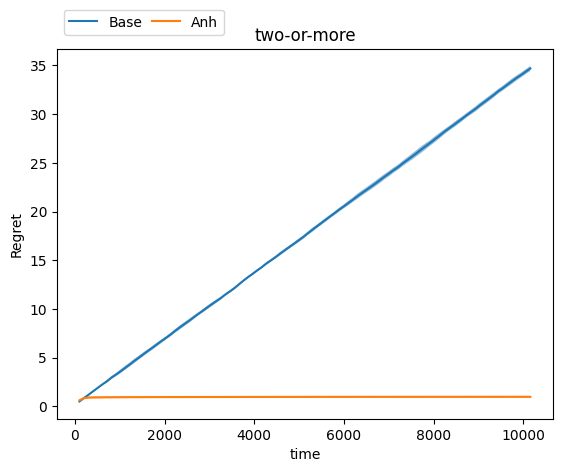

some-other 8028


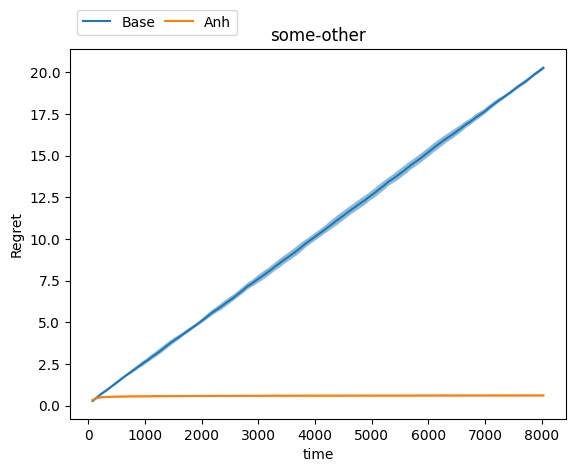

asian 5854


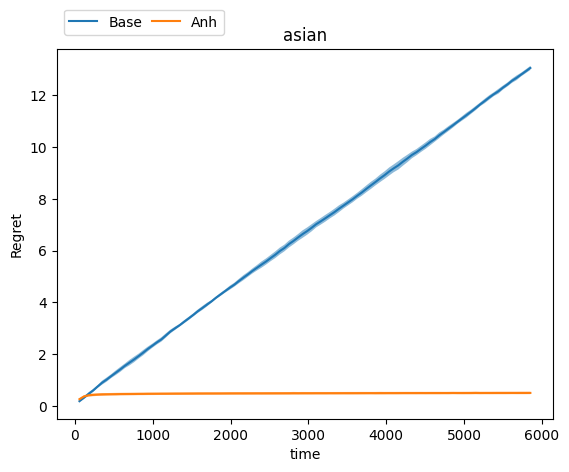

native-am 3063


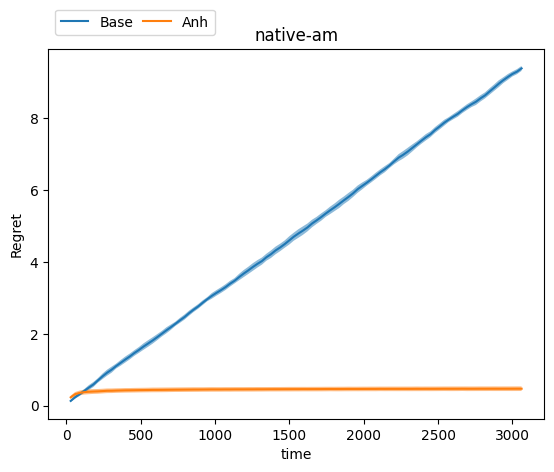

always_on 100000


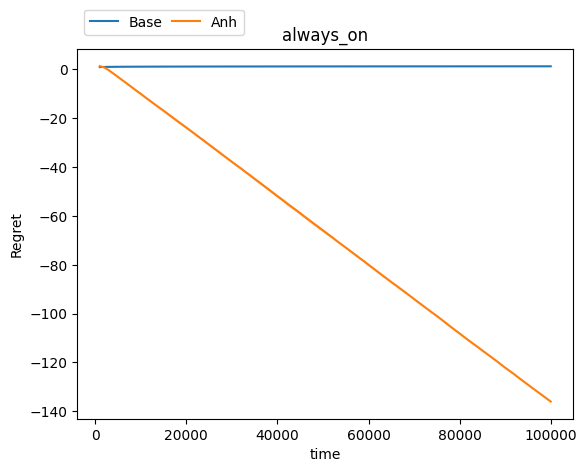

In [39]:
plot_regret_curve_with_std(ds_ymax)

## y_dperm

In [34]:
ds_ydperm = BuildGroupwise_diffseeds(df_dperm, 'y_dperm_active', A_t) # different seeds object
ds_ydperm.build_all_seeds()
ds_ydperm.build_df_res()
ds_ydperm.build_regret_curve()

100%|██████████| 100000/100000 [00:12<00:00, 8056.32it/s]


In [35]:
save_ob('syn_ydperm_seeds.pickle', ds_ydperm)

male 50105


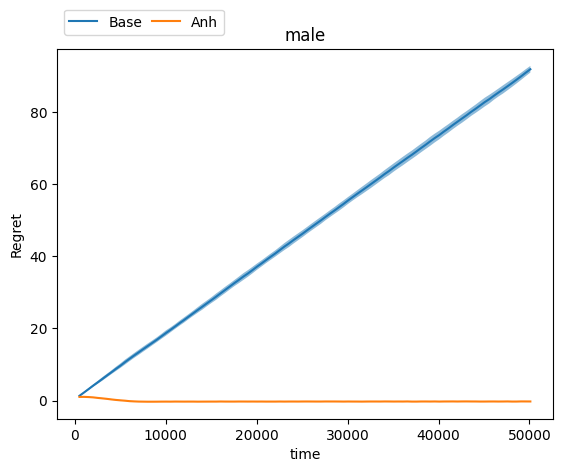

female 49895


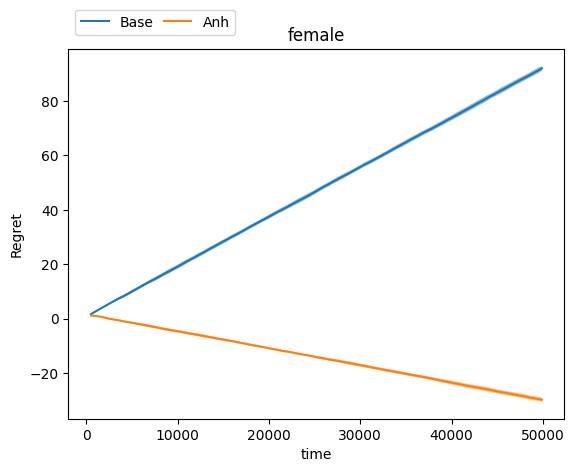

white 60803


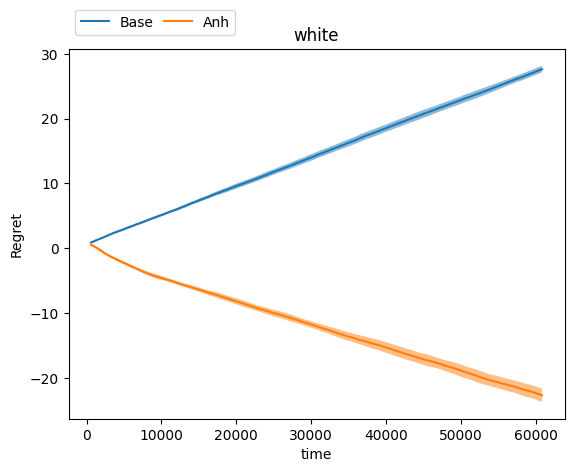

black 12093


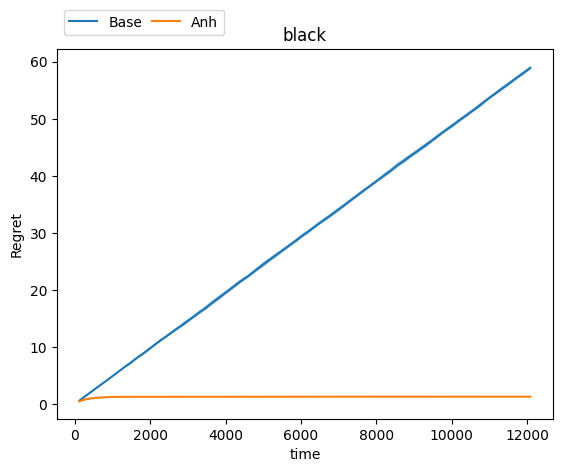

two-or-more 10159


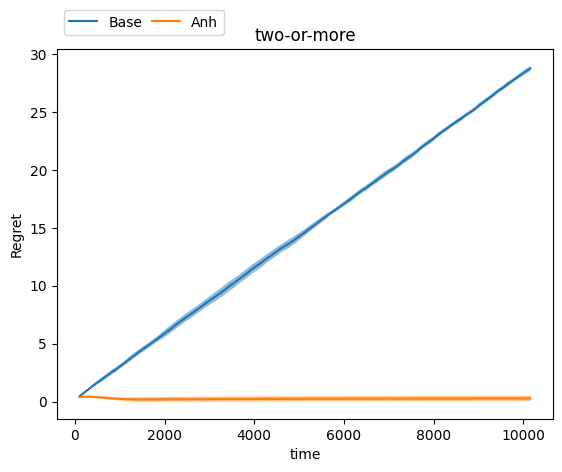

some-other 8028


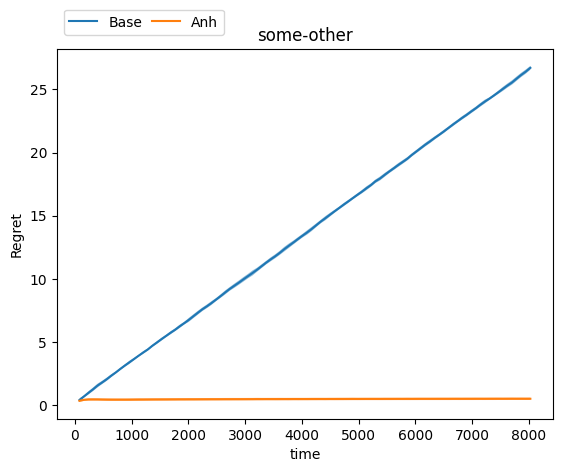

asian 5854


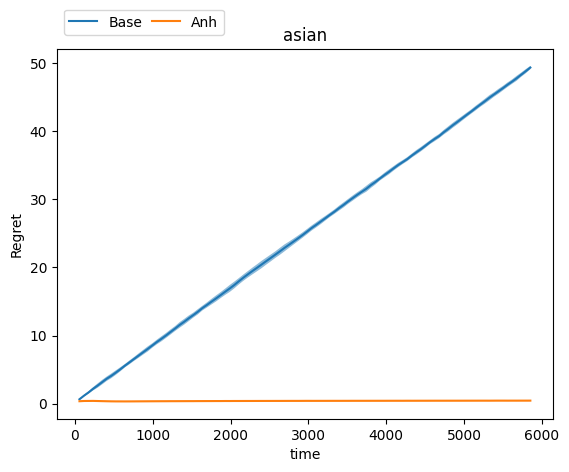

native-am 3063


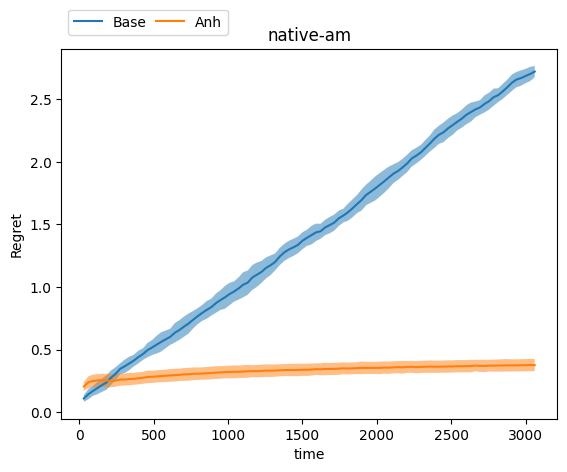

always_on 100000


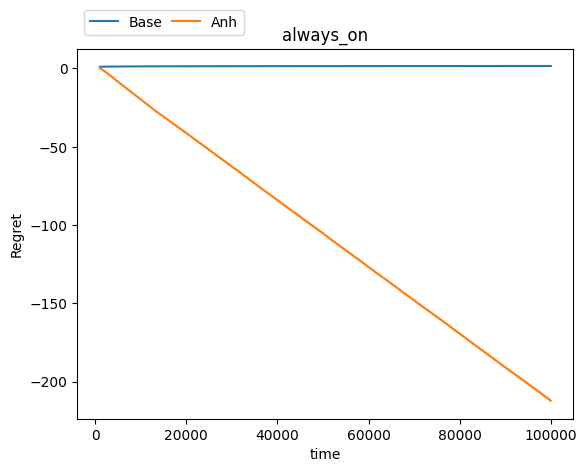

In [40]:
plot_regret_curve_with_std(ds_ydperm)

In [56]:
ds_ydperm.regret_Base_groupwise_array[-1].mean(axis=0), ds_ydperm.regret_Anh_groupwise_array[-1].mean(axis=0)

(array([1.06803598, 1.1571345 , 1.20010793, 1.23045457, 1.2583253 ,
        1.27904895, 1.29788039, 1.3096609 , 1.32205757, 1.33758266,
        1.3496157 , 1.357065  , 1.3645597 , 1.37033496, 1.37975555,
        1.38475987, 1.39482394, 1.40100952, 1.40530543, 1.41510778,
        1.4157257 , 1.42068612, 1.42374506, 1.43195302, 1.43690167,
        1.44208831, 1.44422622, 1.44693611, 1.45420923, 1.45333827,
        1.45929798, 1.46083477, 1.4648874 , 1.46729001, 1.46963954,
        1.47462108, 1.47644928, 1.48237376, 1.48234229, 1.48532136,
        1.48987478, 1.49211653, 1.49196441, 1.49643789, 1.49670016,
        1.50249172, 1.50149124, 1.50489021, 1.50788354, 1.50977811,
        1.51063832, 1.51334109, 1.51652951, 1.51673786, 1.51777434,
        1.52411109, 1.52987579, 1.5260907 , 1.52883429, 1.52867962,
        1.52923604, 1.53444807, 1.53223629, 1.53379111, 1.53848412,
        1.54093714, 1.54118548, 1.54247287, 1.54556006, 1.54333699,
        1.54513958, 1.55030579, 1.54884269, 1.55

## checks which aggregation is the best for Anh

In [44]:
performance_diff(ds_ymean)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
male,72.480970,0.438487,43.300920,0.180897,29.180050,40.258912
female,71.483099,0.437489,41.348306,0.192652,30.134793,42.156529
white,66.242034,0.351214,46.528270,0.249443,19.713764,29.760204
black,24.678840,0.119452,11.580542,0.056245,13.098298,53.075014
two-or-more,19.968421,0.140065,9.921158,0.111478,10.047262,50.315759
some-other,16.440802,0.091614,7.819990,0.068178,8.620812,52.435469
asian,10.488771,0.066394,5.650469,0.059216,4.838302,46.128398
native-am,6.145200,0.036412,3.148795,0.055216,2.996405,48.760083
always_on,143.964069,0.042196,84.649225,0.220194,59.314843,41.201144


In [45]:
performance_diff(ds_ymin)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
male,139.939114,0.999320,50.366692,0.068398,89.572421,64.008138
female,123.080191,1.010976,34.742271,0.089864,88.337920,71.772654
white,161.791384,0.160837,42.504259,0.136593,119.287125,73.728972
black,31.030035,0.081690,15.317970,0.099498,15.712064,50.635020
two-or-more,27.399935,0.045423,7.080857,0.062158,20.319078,74.157395
some-other,20.347220,0.113465,12.246743,0.118528,8.100477,39.811223
asian,14.520519,0.035517,5.311042,0.037260,9.209477,63.423883
native-am,7.930212,0.021916,2.648092,0.035458,5.282120,66.607547
always_on,263.019305,0.068192,85.108964,0.067305,177.910341,67.641552


In [57]:
performance_diff(ds_ymax)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
male,95.450866,0.208796,36.547838,0.132290,58.903028,61.710313
female,110.834513,0.204090,32.463403,0.113734,78.371110,70.710023
white,67.447077,0.672491,35.119523,0.066323,32.327554,47.930252
black,42.113770,0.241830,12.022563,0.071341,30.091206,71.452180
two-or-more,39.921325,0.271504,6.189635,0.110683,33.731690,84.495416
some-other,28.297963,0.118910,8.638441,0.062751,19.659522,69.473278
asian,17.130657,0.081932,4.575932,0.051240,12.554726,73.288055
native-am,11.374586,0.072008,2.465147,0.067353,8.909439,78.327589
always_on,206.285378,0.060368,69.011241,0.147284,137.274137,66.545743


In [58]:
performance_diff(ds_ydperm)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
male,151.078416,0.969686,58.974186,0.039805,92.104230,60.964519
female,210.275274,0.969852,88.587616,0.846986,121.687659,57.870646
white,135.184228,0.525195,84.887756,1.089523,50.296472,37.205873
black,65.238109,0.362435,7.707798,0.062163,57.530311,88.185130
two-or-more,50.796285,0.233941,22.335618,0.230082,28.460666,56.029032
some-other,38.075575,0.160069,11.850005,0.101360,26.225570,68.877673
asian,62.861011,0.253330,13.926701,0.083594,48.934310,77.845248
native-am,9.198484,0.047760,6.853924,0.050642,2.344560,25.488547
always_on,361.353690,0.052545,147.561801,0.836245,213.791889,59.164164
